In [38]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional

In [39]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../../../Data/BNB-USD.csv')
# print(df)
df1=df.reset_index()['Close']


In [40]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [41]:
# 4. Chia train test
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [42]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [43]:


time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [44]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [45]:
# 8. Define LSTM Model

model=Sequential()
model.add(Bidirectional(LSTM(50,return_sequences=True,input_shape=(100,1))))
model.add(Bidirectional(LSTM(50,return_sequences=True)))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [46]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


23/23 [==============================] - 14s 88ms/step - loss: 0.0452 - val_loss: 0.1405
Epoch 2/100
23/23 [==============================] - 0s 8ms/step - loss: 0.0196 - val_loss: 0.0080
Epoch 3/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/100
23/23 [==============================] - 0s 7ms/step - loss: 5.9949e-04 - val_loss: 0.0011
Epoch 5/100
23/23 [==============================] - 0s 8ms/step - loss: 4.0814e-04 - val_loss: 6.0867e-04
Epoch 6/100
23/23 [==============================] - 0s 7ms/step - loss: 3.8010e-04 - val_loss: 6.3162e-04
Epoch 7/100
23/23 [==============================] - 0s 7ms/step - loss: 3.6975e-04 - val_loss: 5.5847e-04
Epoch 8/100
23/23 [==============================] - 0s 10ms/step - loss: 3.5021e-04 - val_loss: 5.7587e-04
Epoch 9/100
23/23 [==============================] - 0s 10ms/step - loss: 3.5970e-04 - val_loss: 5.3273e-04
Epoch 10/100
23/23 [==============================] - 0s 11ms/step - loss

In [47]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 3ms/step


In [48]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)
#MAPE
mape = mean_absolute_percentage_error(ytest, y_pred)
print("The mean absolute percentage error (MAPE) on test set: {:.3f}".format(mape))
# EVS
evs = explained_variance_score(ytest, y_pred)
print("The explained variance score (EVS) on test set: {:.3f}".format(evs))


Testing RMSE: 0.23682200226625852
The mean absolute percentage error (MAPE) on test set: 0.040
The explained variance score (EVS) on test set: 0.982


In [49]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
train_data=scaler.inverse_transform(train_data)
test_data=scaler.inverse_transform(test_data)
val_data=scaler.inverse_transform(val_data)

In [50]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=97
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, x_input.shape[1], 1))
        #print(x_input)
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, x_input.shape[1],1))
        yhat = model.predict(x_input)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [299.261169 303.046448 305.504089 300.612335 307.307648 304.866547
 308.123108 306.244324 317.336212 307.068878 312.361053 317.472595
 323.349792 332.268677 330.617096 327.869354 324.627167 333.227875
 328.088654 305.960419 305.954132 310.616028 312.929657 294.475342
 296.120361 317.16922  304.763702 313.377991 316.682709 311.935852
 315.377441 311.472015 312.781128 308.533936 302.053711 302.384613
 308.99707  304.855804 301.474823 302.907471 299.946167 290.282837
 289.503876 288.699707 288.054962 289.343689 286.867004 277.296112
 277.419586 277.961426 289.675781 308.912201 309.370789 307.124939
 329.86087  339.081146 331.524292 336.978241 332.923004 335.309235
 321.887726 329.837006 322.359344 322.673065 328.888    310.949127
 313.26062  313.841766 316.567566 317.040009 315.217316 313.928619
 308.562378 310.994843 314.063171 312.454651 310.699493 310.634735
 312.872253 318.379059 322.75827  318.953766 324.94809  329.173859
 333.407288 348.220917 339.99411  343.193451 322.7

1/1 [==============================] - 4s 4s/step
0 day output [[6.7137322]]
1 day input [303.046448   305.504089   300.612335   307.307648   304.866547
 308.123108   306.244324   317.336212   307.068878   312.361053
 317.472595   323.349792   332.268677   330.617096   327.869354
 324.627167   333.227875   328.088654   305.960419   305.954132
 310.616028   312.929657   294.475342   296.120361   317.16922
 304.763702   313.377991   316.682709   311.935852   315.377441
 311.472015   312.781128   308.533936   302.053711   302.384613
 308.99707    304.855804   301.474823   302.907471   299.946167
 290.282837   289.503876   288.699707   288.054962   289.343689
 286.867004   277.296112   277.419586   277.961426   289.675781
 308.912201   309.370789   307.124939   329.86087    339.081146
 331.524292   336.978241   332.923004   335.309235   321.887726
 329.837006   322.359344   322.673065   328.888      310.949127
 313.26062    313.841766   316.567566   317.040009   315.217316
 313.928619   30

In [51]:
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)
df_test.index += df_train.index.stop
df_val = pd.DataFrame(val_data)
df_val.index += df_test.index.stop

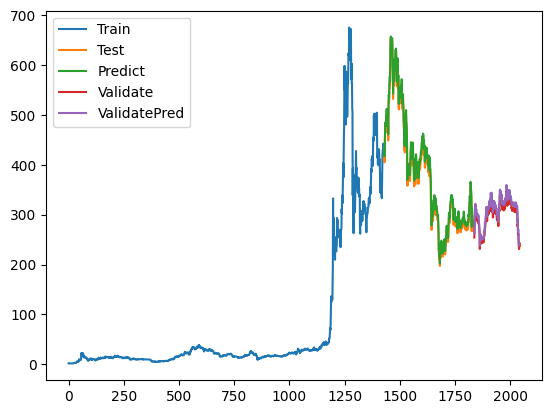

In [52]:
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)
df_test.index += df_train.index.stop
df_val = pd.DataFrame(val_data)
df_val.index += df_test.index.stop
lst_output = scaler.inverse_transform(lst_output)
plt.plot(df_train.index, df_train)
plt.plot(df_test.index, df_test)
plt.plot(pd.RangeIndex(start=df_test.index.start, stop=df_test.index.stop-2), y_pred)
plt.plot(df_val.index, df_val)
plt.plot(pd.RangeIndex(start=df_val.index.start, stop=df_val.index.stop-2), y_pred_val)
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

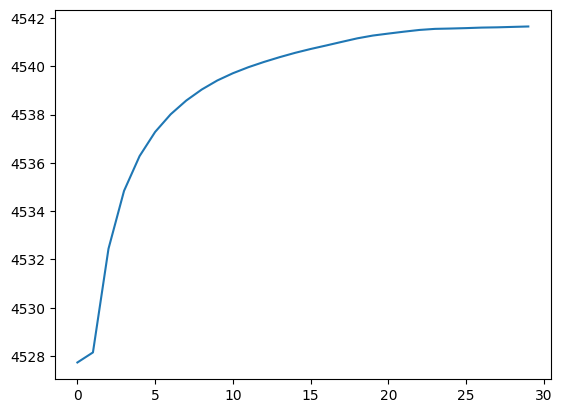

In [53]:
plt.plot(lst_output)
